# Convolutional Layers 
We will first import some of the important packages and initialize them for this tutorial.

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. Implement the forward pass for the convolution layer in the function template defined below.

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.


In [2]:
def conv_forward_naive(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.

  The input consists of N data points, each with C channels, height H and width
  W. We convolve each input with F different filters, where each filter spans
  all C channels and has height HH and width HH.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
      horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """
  outShape = (int(1 + (x.shape[2] + 2 * conv_param['pad'] - w.shape[2]) / conv_param['stride']), \
              int(1 + (x.shape[3] + 2 * conv_param['pad'] - w.shape[3]) / conv_param['stride']))
  out = np.zeros((x.shape[0], w.shape[0], outShape[0], outShape[1]))
  #############################################################################
  # TODO: Implement the convolutional forward pass.                           #
  # Hint: you can use the function np.pad for padding.                        #
  #############################################################################
  x = np.pad(x, [(0, 0), (0, 0), (conv_param['pad'], conv_param['pad']), (conv_param['pad'], conv_param['pad'])], 'constant')
  for inputIter in range(x.shape[0]):
    for filterIter in range(w.shape[0]):
      hIter = 0
      for i in range(out.shape[2]):
        wIter = 0
        for j in range(out.shape[2]):
          out[inputIter, filterIter, i, j] = np.sum(np.multiply(x[inputIter, :, hIter:hIter+w.shape[2], wIter:wIter+w.shape[3]], w[filterIter, :, :, :])) + b[filterIter]
          wIter += conv_param['stride']
        hIter += conv_param['stride']
   
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  cache = (x, w, b, conv_param)
  return out, cache

# Test the implementation

You can test your implementation of the function conv_forward_naive by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

/home/siddiqui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/siddiqui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/siddiqui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


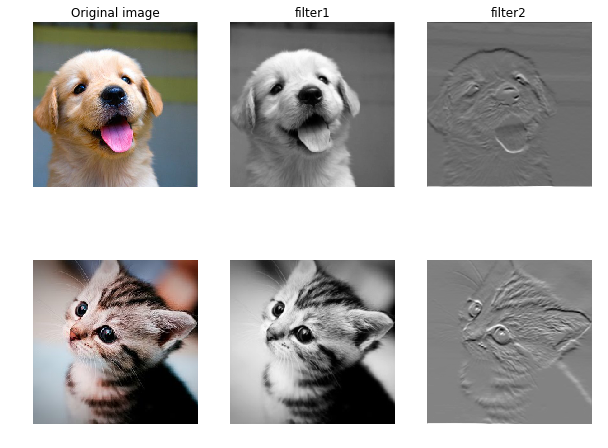

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]


# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

    
def show_batch2(input1, input2, out):
    #datasample 0
    plt.subplot(2, 3, 1)
    imshow_noax(input1, normalize=False)
    plt.title('Original image')
    plt.subplot(2, 3, 2)
    imshow_noax(out[0, 0])
    plt.title('filter1')
    plt.subplot(2, 3, 3)
    imshow_noax(out[0, 1])
    plt.title('filter2')
    plt.subplot(2, 3, 4)
    
    #datasample 1
    imshow_noax(input2, normalize=False)
    plt.subplot(2, 3, 5)
    imshow_noax(out[1, 0])
    plt.subplot(2, 3, 6)
    imshow_noax(out[1, 1])
    plt.show()
    

show_batch2(puppy, kitten_cropped, out)

# More filters
Initialize with more filters for different operations:

1. For smoothing.
2. Filter of your choice to solve a problem.

Show the output after convolution.


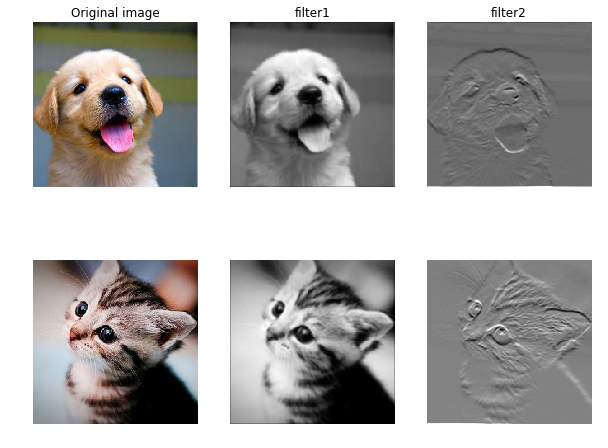

In [5]:
#############################################################################
# TODO: initialize the weights                          #
#############################################################################
#filter 1
w[0, 0, :, :] = [[1.0/9.0, 1.0/9.0, 1.0/9.0], [1.0/9.0, 1.0/9.0, 1.0/9.0], [1.0/9.0, 1.0/9.0, 1.0/9.0]] # Box filter
w[0, 1, :, :] = [[1.0/16.0, 1.0/8.0, 1.0/16.0], [1.0/8.0, 1.0/4.0, 1.0/8.0], [1.0/16.0, 1.0/8.0, 1.0/16.0]] # Gaussian Filter
w[0, 2, :, :] = [[0, 1.0/5.0, 0], [1.0/5.0, 1.0/5.0, 1.0/5.0], [0, 1.0/5.0, 0]] # Grayscale
#############################################################################
# end of initialization             #
#############################################################################

out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})
show_batch2(puppy, kitten_cropped, out)